In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from typing import List, Tuple, Dict
import warnings
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

Connect to the dataset

In [111]:
db = sqlite3.connect("aosp_acs.db", check_same_thread=False)

Queries

In [101]:
def cursor_to_dataframe(cursor):
    with warnings.catch_warnings():
        # TODO: pandas 2.1.0 has a FutureWarning for concatenating DataFrames with Null entries
        warnings.filterwarnings("ignore", category=FutureWarning)
        columns = [desc[0] for desc in (cursor.description)]
        df_records = pd.DataFrame(columns=columns)
        for row in cursor:
            df_temp = pd.DataFrame([row], columns=columns)
            if df_temp.empty:
                continue
            df_records = pd.concat([df_records, df_temp])
    return df_records.infer_objects().reset_index(drop=True)

In [4]:
def acs_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT count(id) as ac_count,path,ac,loc FROM ac_reports WHERE path IN (SELECT path FROM files WHERE files.project_name = ?) GROUP BY path,ac",(project_name,))
    return cursor_to_dataframe(cursor)

def ck_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * from classes WHERE file_path IN (SELECT path FROM files WHERE files.project_name = ?)", (project_name,))
    df = cursor_to_dataframe(cursor)
    NUMERIC_FIELDS = ['cbo', 'cboModified', 'fanin',
       'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom_normalized', 'tcc',
       'lcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty',
       'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty',
       'visibleMethodsQty', 'abstractMethodsQty', 'finalMethodsQty',
       'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty',
       'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
       'defaultFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty', 'nosi',
       'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty',
       'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty',
       'assignmentsQty', 'mathOperationsQty', 'variablesQty',
       'maxNestedBlocksQty', 'anonymousClassesQty', 'innerClassesQty',
       'lambdasQty', 'uniqueWordsQty', 'modifiers', 'logStatementsQty']
    for field in NUMERIC_FIELDS:
        df[field] = df[field].astype(float)
    return df

def ck_in_file(file_name: str):
    cursor = db.execute("SELECT * from classes WHERE file_path = ?", (file_name,))
    df = cursor_to_dataframe(cursor)
    return df


"""Prevalence report of AC in a project"""
def report_types_of_acs(project_name):
    sql = f"SELECT ac, count(id) as qty FROM ac_reports WHERE project_name LIKE '{project_name}' GROUP BY ac ORDER BY qty DESC"
    cursor = db.execute(sql)
    return cursor_to_dataframe(cursor)

def files_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * FROM files WHERE project_name = ?", (project_name,))
    return cursor_to_dataframe(cursor)

def loc_of_file(file_name) -> int:
    cursor = db.execute("SELECT loc FROM files WHERE path = ?", (file_name,))
    return int(next(cursor)[0])

def number_of_acs_in_files(project_name) -> dict:
    sql = f"""
    SELECT files.path, coalesce(ac_count, 0) AS count_acs
    FROM files
    LEFT JOIN
    (SELECT ac_reports.path AS ac_reports_path, count(id) AS ac_count
    FROM ac_reports
    WHERE project_name = '{project_name}'
    GROUP BY ac_reports.path)
    ON files.path = ac_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_acs DESC;
    """
    cursor = db.execute(sql)
    return {k: v for k,v in cursor}

def report_files_with_acs(project_name) -> pd.Series:
    sql = f"SELECT DISTINCT path FROM ac_reports WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    return pd.Series([tup[0] for tup in cursor])

def report_files_without_acs(project_name) -> pd.Series:
    sql = f"SELECT path FROM files WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    all_files = [tup[0] for tup in cursor]
    files_with_ac = report_files_with_acs(project_name)
    return pd.Series([file for file in all_files if file not in files_with_ac])

def report_projects_with_atoms() -> pd.Series:
    sql = "SELECT project_name from ac_reports GROUP BY project_name"
    cursor = db.execute(sql)
    all_projs_with_acs = [tup[0] for tup in cursor]
    return pd.Series(all_projs_with_acs)

In [5]:
report_projects_with_atoms()

0                                art
1                  bootable/recovery
2                         build/make
3                                cts
4                             dalvik
                   ...              
326            tools/platform-compat
327                   tools/security
328     tools/test/graphicsbenchmark
329    tools/tradefederation/contrib
330       tools/tradefederation/core
Length: 331, dtype: object

In [6]:
def identity(x):
    return x

Get the list of core apps

In [7]:
cursor = db.execute("SELECT * FROM files;")
ALL_PROJECTS = set()
for path,loc, project_name in cursor:
    ALL_PROJECTS.add(project_name)

In [8]:
cursor = db.execute("SELECT ac FROM ac_reports;")
ALL_ACS = set()
for ac, in cursor:
    ALL_ACS.add(ac)

In [9]:
cursor = db.execute("SELECT * FROM files WHERE path LIKE '/AOSP/packages/apps%';")
apps_set = set()
for path,loc, project_name in cursor:
    apps_set.add(project_name)

In [10]:
apps_data :Dict[str, Dict[str, pd.DataFrame]] = {}
for project in apps_set:
    apps_data[project] = {
        "ck": ck_in_a_project(project),
        "acs": acs_in_a_project(project),
        "files": files_in_a_project(project)
    }

print("Projects processed: ", len(apps_data.keys()))

Projects processed:  65


AVG, median, percentiles...

In [11]:
def process_ck(df: pd.DataFrame) -> pd.DataFrame:
    pd_recast_numeric = pd.DataFrame()
    output = pd.DataFrame()
    for col in df.columns:
        try:
            if col in ["id", "file_path"]:
                raise ValueError
            pd_recast_numeric[col] = pd.to_numeric(df[col])
            # output[f"{col}__mean"] = pd_recast_numeric[col].mean(skipna=True)
            # output[f"{col}__median"] = pd_recast_numeric[col].median(skipna=True)
            # output[f"{col}__90_perc"] = pd_recast_numeric[col].quantile(.90 )
        except ValueError:
            continue
        except Exception as e:
            print("Exception: ", e)
            print(f"Skipping column {col} of type {pd_recast_numeric[col].dtype}")
    return pd_recast_numeric.describe()

In [12]:
apps_data[project_name]["acs"].loc[apps_data[project_name]["acs"]["ac"] == "Logic as Control Flow"]["ac_count"].sum()

163

In [13]:
%%script echo skipping
def countacs(project_name: str) -> pd.DataFrame:
    loc_sum = apps_data[project_name]["files"]["loc"].sum()
    ac_count = apps_data[project_name]["acs"]["ac_count"].sum()
    loc_by_acs = loc_sum/ac_count if ac_count > 0 else -1
    return pd.DataFrame([(loc_sum, ac_count, loc_by_acs)], columns=["loc_sum", "ac_count", "loc_by_acs"])



df_apps_ac: pd.DataFrame = pd.DataFrame()
for idx, project_name in enumerate(apps_set):
    apps_ac_map = countacs(project_name)
    apps_ac_map = apps_ac_map.assign(project_name=[project_name])
    df_apps_ac = pd.concat([df_apps_ac, apps_ac_map])
df_apps_ac = df_apps_ac.reset_index(drop=True)

df_loc_by_acs = df_apps_ac.sort_values("loc_by_acs", ascending=True)

fig, ax = plt.subplots()


ax.bar(df_loc_by_acs["project_name"], df_loc_by_acs["loc_by_acs"], 0.9)
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.yaxis.set_label_text("Lines of code per AC")
ax.xaxis.set_label_text("Project Name")

plt.xticks(rotation=90)
plt.savefig("fig.png")


skipping


In [14]:
def plot_ac_report_bar(project_name):
    df_report = report_types_of_acs(project_name)
    df_report = df_report.assign(perc=(df_report["qty"] / df_report["qty"].sum()).astype(float).round(2))
    df_report = df_report.assign(label=df_report["ac"] + " " + df_report["perc"].astype(str))
    fig, ax = plt.subplots()
    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(5)
    wedges, _ = ax.pie(df_report["perc"], wedgeprops=dict(width=0.5), startangle=0)

    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        Epsilon = .00001
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        if ang == 180:
            ang = 179
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(df_report["label"][i], xy=(x + Epsilon, y + Epsilon), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    ax.set_title(f"Prevalence of {project_name}")
    plt.savefig(f"imgs/prevalence_{project_name.replace('/', '_')}.png")
    plt.close()



In [15]:
%%script echo skipping
for project_name in apps_set:
    try:
        plot_ac_report_bar(project_name)
    except:
        print(f"Failed to render graph for {project_name}")

skipping


In [16]:
def correlation_with_loc(project_name):
    corr_test = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    corr_test["ac_count"] = corr_test["ac_count"].astype(int)
    corr_test["loc"] = corr_test["loc"].astype(int)
    return corr_test.corr("pearson", numeric_only=True)["ac_count"]["loc"]

def export_ac_cout_loc(project_name:str):
    df = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    escaped_project_name = project_name.replace("/","_")
    df.to_csv(f"./corrs/{escaped_project_name}.csv")

In [17]:
for proj in apps_set:
    export_ac_cout_loc(proj)

In [18]:
corrs = [(projname, correlation_with_loc(projname)) for projname in apps_set]

### CellBroadcastReceiver analysis

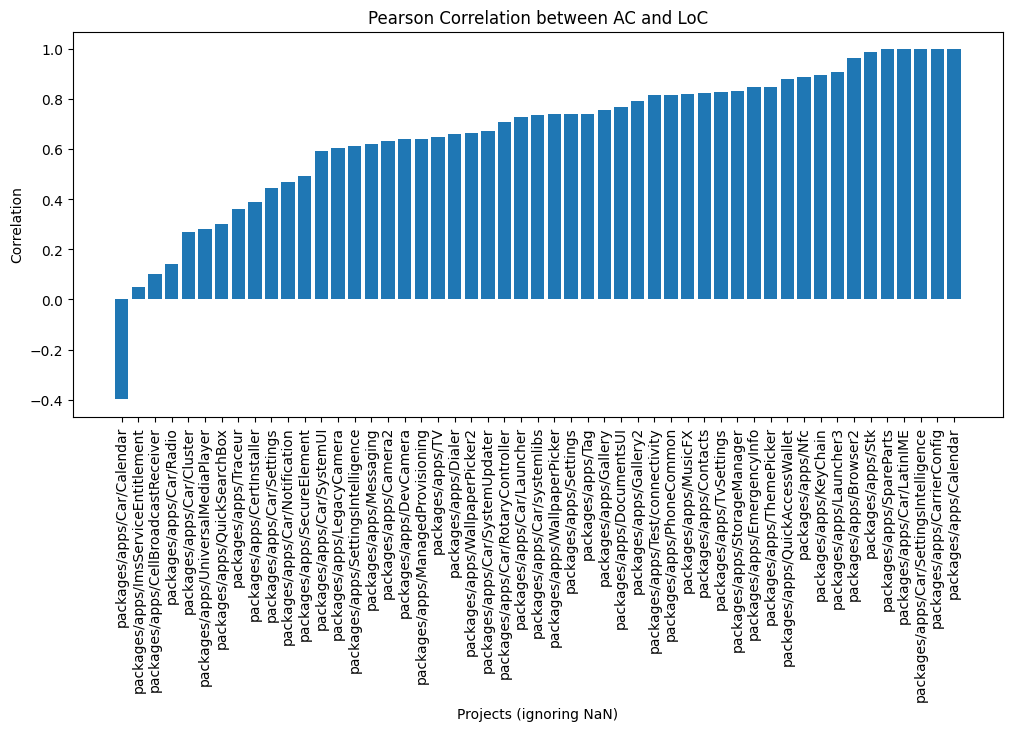

In [105]:
corrs = [c for c in corrs if not np.isnan(c[1])]
s = pd.DataFrame(np.array(corrs), columns=["project_name", "correlation"])
s["correlation"] = s["correlation"].astype(float)
s = s.sort_values(by="correlation")

fig, ax = plt.subplots()
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.bar(s["project_name"], s["correlation"])
ax.set_title("Pearson Correlation between AC and LoC")
ax.yaxis.set_label_text("Correlation")
ax.xaxis.set_label_text("Projects (ignoring NaN)")
plt.xticks(rotation=90)
plt.show()

## Filewise analysis

In [106]:
agg_methods = {'cbo': 'sum',
               'cboModified': 'sum',
               'fanin': 'sum',
               'fanout': 'sum',
               'wmc': 'sum',
               'dit': 'sum',
               'noc': 'sum',
               'rfc': 'sum',
               'lcom': 'sum',
               'lcom_normalized': 'mean',
               'tcc': 'mean',
               'lcc': 'mean',
               'totalMethodsQty': 'sum',
               'staticMethodsQty': 'sum',
               'publicMethodsQty': 'sum',
               'privateMethodsQty': 'sum',
               'protectedMethodsQty': 'sum',
               'defaultMethodsQty': 'sum',
               'visibleMethodsQty': 'sum',
               'abstractMethodsQty': 'sum',
               'finalMethodsQty': 'sum',
               'synchronizedMethodsQty': 'sum',
               'totalFieldsQty': 'sum',
               'staticFieldsQty': 'sum',
               'publicFieldsQty': 'sum',
               'privateFieldsQty': 'sum',
               'protectedFieldsQty': 'sum',
               'defaultFieldsQty': 'sum',
               'finalFieldsQty': 'sum',
               'synchronizedFieldsQty': 'sum',
               'nosi': 'sum',
               'loc': 'sum', # does not matter, will be replaced
               'returnQty': 'sum',
               'loopQty': 'sum',
               'comparisonsQty': 'sum',
               'tryCatchQty': 'sum',
               'parenthesizedExpsQty': 'sum',
               'stringLiteralsQty': 'sum',
               'numbersQty': 'sum',
               'assignmentsQty': 'sum',
               'mathOperationsQty': 'sum',
               'variablesQty': 'sum',
               'maxNestedBlocksQty': 'sum',
               'anonymousClassesQty': 'sum',
               'innerClassesQty': 'sum',
               'lambdasQty': 'sum',
               'uniqueWordsQty': 'sum',
               'modifiers': 'sum',
               'logStatementsQty': 'sum'}

In [107]:
pd.Series(agg_methods).to_csv("agg_methods.csv")

In [108]:
def ac_ck_pipeline(project_name: str):
    df_ck = ck_in_a_project(project_name)
    
    df_ck = df_ck.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck["file_path"] = df_ck["file_path"].astype("str")
    df_ck["path"] = df_ck["file_path"]
    df_files = files_in_a_project(project_name)[["path", "loc"]]
    df_files["path"] = df_files["path"].astype(str)
    df_ck.drop(columns=["loc"], inplace=True) # drop loc, use from files instead.

    pd_merged = pd.merge(df_files, df_ck, how="left", on="path")
    df_ac = acs_in_a_project(project_name)[["path", "ac_count"]].groupby("path").agg({"ac_count": "sum"}).reset_index()

    pd_merged = pd.merge(pd_merged, df_ac, how="left", on="path")
    pd_merged.infer_objects(copy=False)
    pd_merged["ac_count"] = pd_merged["ac_count"].astype(float).fillna(0).astype(int)
    pd_merged["loc"] = pd_merged["loc"].astype(int)
    pd_merged["atom_rate"] = pd_merged["ac_count"] / pd_merged["loc"]
    pd_merged.drop(columns=["file_path"], inplace=True)
    return pd_merged


In [109]:
def get_correlations(projects: List[str]):
    df_correlations = pd.DataFrame()
    records = []
    for i, project_name in enumerate(projects):
        record = ac_ck_pipeline(project_name)
        # record["files_with_ac"] = pd_merged.query("ac_count > 0")["file_path"].size
        # record["diffusion_file"] = pd_merged["file_path"].size / pd_merged.query("ac_count > 0")["file_path"]
        record = record.corr(method="pearson", numeric_only=True)["ac_count"]
        record["project_name"] = project_name
        records.append(record)
    df_correlations = pd.DataFrame.from_records(records)
    return df_correlations

# df_correlations = get_correlations(ALL_PROJECTS)

In [110]:
# df_correlations.plot(kind="box", figsize=(15,6), rot=90, title="Pearson Correlation with ac_count")

In [111]:
%%script echo skipping
df_correlations_atom_rate = pd.DataFrame()
records = []
for i, project_name in enumerate(apps_set):
    record = ac_ck_pipeline(project_name)
    # record["files_with_ac"] = pd_merged.query("ac_count > 0")["file_path"].size
    # record["diffusion_file"] = pd_merged["file_path"].size / pd_merged.query("ac_count > 0")["file_path"]
    record = record.corr(method="pearson", numeric_only=True)["atom_rate"]
    record["project_name"] = project_name
    records.append(record)
df_correlations_atom_rate = pd.DataFrame.from_records(records)

df_correlations_atom_rate.plot(kind="box", figsize=(15,6), rot=90, title="Pearson Correlation with atom_rate")

skipping


In [112]:
# df_correlations.to_csv("corr_per_project_mean.csv", index=False)

In [113]:
records = []
for app in apps_set:
    df_files = files_in_a_project(app)
    df_ac = acs_in_a_project(app)
    serie_files_with_ac = report_files_with_acs(app)
    records.append({
        "project_name": app,
        "file_qty": df_files.size,
        "loc_sum": df_files["loc"].sum(),
        "files_with_ac_perc": serie_files_with_ac.size / df_files.size
    })
df_metrics = pd.DataFrame.from_records(records)
df_metrics

,project_name,file_qty,loc_sum,files_with_ac_perc
0,packages/apps/EmergencyInfo,159,7073,0.088050
1,packages/apps/DeskClock,36,2116,0.027778
2,packages/apps/Nfc,147,18266,0.210884
3,packages/apps/Car/SystemUI,780,46453,0.107692
4,packages/apps/Contacts,1269,94386,0.167061
...,...,...,...,...
60,packages/apps/SafetyRegulatoryInfo,3,46,0.000000
61,packages/apps/Car/Provision,9,829,0.111111
62,packages/apps/SystemUIGo,18,596,0.000000
63,packages/apps/Car/SystemUpdater,15,800,0.200000


## Projectwise analysis

In [114]:
def ac_ck_pipeline_projectwise(project_name: str):
    agg_methods_copy = agg_methods.copy()
    df_merged = ac_ck_pipeline(project_name)
    df_merged.drop(columns=["path"], inplace=True)
    # Aggregation dict
    agg_methods_copy["loc"] = "sum" # sum aggregation for LoC
    agg_methods_copy["ac_count"] = "sum" # sum aggregation for ac count
    df_merged = df_merged.agg(agg_methods_copy, numeric_only=True)
    df_merged["project_name"] = project_name

    # put project_name first
    columns = list(df_merged.index)
    columns.insert(0, columns.pop())
    df_merged = df_merged[columns]
    return df_merged

In [115]:
records: List[pd.Series] = []
for project_name in apps_set:
    record = ac_ck_pipeline_projectwise(project_name)
    nfa = report_files_with_acs(project_name).size
    nft = files_in_a_project(project_name).size
    record["acdif"] = nfa/nft
    record["acden"] = record["ac_count"] / nft
    records.append(record)
df_project_wise_analysis = pd.concat(records, axis=1).T
df_project_wise_analysis = df_project_wise_analysis.infer_objects()
for col in df_project_wise_analysis.columns:
    if col != "project_name":
        df_project_wise_analysis[col] = df_project_wise_analysis[col].astype(float)
df_project_wise_corr = df_project_wise_analysis.corr(method="pearson", numeric_only=True)


KeyboardInterrupt: 

In [ ]:
df_project_wise_corr["ac_count"].sort_values(ascending=False)

ac_count                  1.000000
comparisonsQty            0.985469
numbersQty                0.983893
loopQty                   0.972537
finalFieldsQty            0.971258
wmc                       0.970896
returnQty                 0.970748
maxNestedBlocksQty        0.970414
parenthesizedExpsQty      0.969444
assignmentsQty            0.962177
fanin                     0.962015
privateMethodsQty         0.957066
innerClassesQty           0.956814
anonymousClassesQty       0.955835
tryCatchQty               0.953898
staticFieldsQty           0.949068
variablesQty              0.945174
uniqueWordsQty            0.940285
stringLiteralsQty         0.936254
totalFieldsQty            0.936142
totalMethodsQty           0.935798
lcom                      0.931430
visibleMethodsQty         0.930144
loc                       0.928824
nosi                      0.928719
publicMethodsQty          0.925125
protectedFieldsQty        0.919935
rfc                       0.919153
staticMethodsQty    

In [ ]:
df_project_wise_analysis.to_csv("df_project_wise_analysis.csv", index=False)

## Atom breakdown per project

In [ ]:
atom_breakdown: List[Dict[str, pd.DataFrame]] = []
for project_name in ALL_PROJECTS:
    atom_breakdown.append({"project_name": project_name, "breakdown": report_types_of_acs(project_name)})

In [ ]:
def convert_name(string:str):
    return string.replace("/", "_")

for entry in atom_breakdown:
    entry["breakdown"].to_csv(f"ac_breakdown/ac_breakdown_{convert_name(entry['project_name'])}.csv", index=False)

In [ ]:
df_ac_prevalence = pd.Series([0] * len(ALL_ACS),index=ALL_ACS)
for entry in atom_breakdown:
    atoms_in_breakdown = entry["breakdown"]['ac'].to_list()
    for atom in ALL_ACS:
        df_ac_prevalence[atom] = df_ac_prevalence[atom] + (1 if atom in atoms_in_breakdown else 0)
df_ac_prevalence = df_ac_prevalence.apply(lambda x: x / len(ALL_PROJECTS) * 100)


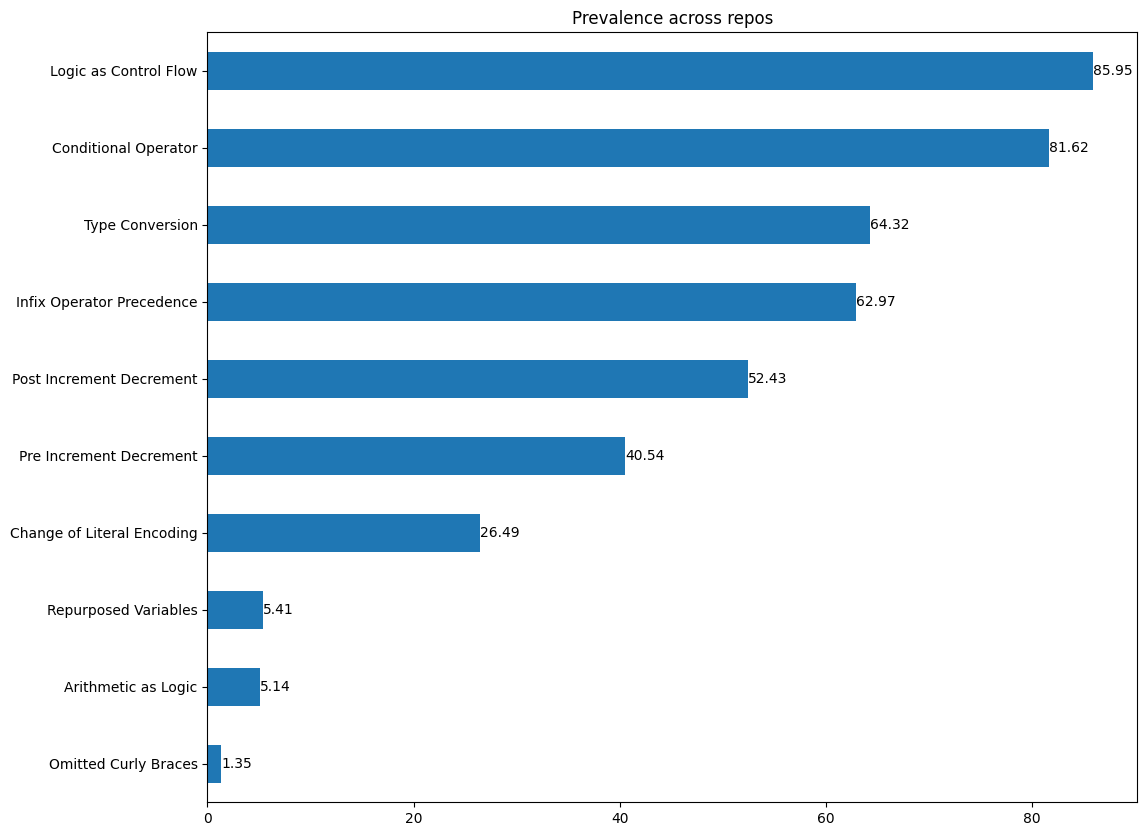

In [ ]:
ax = df_ac_prevalence.sort_values(ascending=True).plot(kind="barh", figsize=(12,10), title="Prevalence across repos")
ax.bar_label(ax.containers[0], fmt="%.2f")
plt.xticks = [i for i in range(0, 100, 10)]

In [ ]:
df_ac_prevalence.to_csv("Prevalencia total.csv")

In [ ]:
for initial in set(p.split("/")[0] for p in ALL_PROJECTS if "/" in p):
    print(initial)

build
prebuilts
test
tools
bootable
developers
system
frameworks
device
external
hardware
packages


In [ ]:
def generate_breakdown_chart(filter_str: str, save=""):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]

    _df_ac_prevalence = pd.Series([0] * len(ALL_ACS),index=ALL_ACS)
    if len(filtered_projects) == 0:
        raise Exception(f"No project matches the filter string \"{filter_str}\"")
    projs_with_ac = 0
    for _project_name in filtered_projects:
        _atoms_in_breakdown = report_types_of_acs(_project_name)['ac'].to_list()
        if _atoms_in_breakdown:
            projs_with_ac += 1
        for atom in ALL_ACS:
            _df_ac_prevalence[atom] = _df_ac_prevalence[atom] + (1 if atom in _atoms_in_breakdown else 0)
    _df_ac_prevalence = _df_ac_prevalence.apply(lambda x: x / projs_with_ac * 100)
    ax = _df_ac_prevalence.sort_values().plot(kind="barh",figsize=(12,8), title=f"Prevalence across \"{filter_str}\"")
    ax.bar_label(ax.containers[0], fmt="%.2f")
    plt.xticks = [i for i in range(0, 100, 10)]
    plt.tight_layout()
    if save:
        plt.savefig(f"{save}.png", dpi=300)
        _df_ac_prevalence.to_csv(f"{save}.csv")
    plt.close()


In [ ]:
def generate_frequency_reports(filter_str: str = None, save=""):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]

    _df_ac_frequency = pd.DataFrame([[0] * len(ALL_ACS)],columns=list(ALL_ACS))
    if len(filtered_projects) == 0:
        raise Exception(f"No project matches the filter string \"{filter_str}\"")
    for _project_name in filtered_projects:
        report = report_types_of_acs(_project_name)
        cols = report["ac"].to_list()
        qtds = report["qty"].to_list()
        report = pd.DataFrame([qtds], columns=cols)
        _df_ac_frequency = _df_ac_frequency.add(report, fill_value=0)
    if save:
        _df_ac_frequency.to_csv(f"{save}.csv", index=False)
    return _df_ac_frequency

In [ ]:
def generate_distribution(filter_str: str = None):
    filtered_projects = ALL_PROJECTS
    if filter_str:
        filtered_projects = [p for p in filter(lambda x: filter_str in x, ALL_PROJECTS)]
    categories = set(p.split("/")[0] for p in ALL_PROJECTS)
    records = []
    for _project_name in filtered_projects:
        with_acs = report_files_with_acs(_project_name)
        without_acs = report_files_without_acs(_project_name)
        records.append({
            "project_name": _project_name,
            "files_with_acs": with_acs.size,
            "files_without_acs": without_acs.size
        })
    _df = pd.DataFrame.from_records(records)
    grouped = []
    for c in categories:
        filtered_by_category = _df.query("project_name.str.startswith(@c)", engine="python")
        _agg = filtered_by_category.sum(numeric_only=True)
        grouped.append(
            {
                "project_name": c,
                "files_with_acs": _agg["files_with_acs"],
                "files_without_acs": _agg["files_without_acs"]
            }
        )
    return pd.DataFrame.from_records(grouped)

In [ ]:
pd_all_distribution = generate_distribution()

In [ ]:
pd_all_distribution.to_csv("All distribution.csv", index=None)

In [ ]:
for initial in set(p.split("/")[0] for p in ALL_PROJECTS if "/" in p):
    try:
        generate_breakdown_chart(initial, save=f"breakdown_charts/{initial}.png")
    except Exception as ex:
        print(ex)

RQ1- Como se dá a distribuição dos ACs no ecosistema? ( frequência e prevalência geral de todos os 370 repos)

In [ ]:
generate_breakdown_chart(None, save="results/rq1")

In [ ]:
tst = generate_frequency_reports(save="results/rq1_frequency")

In [ ]:
tst.to_csv("Frequency Reports.csv", index=None)

([<matplotlib.patches.Wedge at 0x7281d7a34a90>,
 [Text(1.0999997586401775, 0.0007286916710677585, 'Arithmetic as Logic'),
  Text(1.0990408594744223, 0.045925909960753894, 'Change of Literal Encoding'),
  Text(0.782971519036973, 0.7726290185962053, 'Conditional Operator'),
  Text(-0.24572753736721764, 1.072202395716146, 'Infix Operator Precedence'),
  Text(-1.0992451399158074, -0.04074459929214146, 'Logic as Control Flow'),
  Text(-0.49969161977127335, -0.9799532055819611, 'Omitted Curly Braces'),
  Text(-0.3583095216516268, -1.0400068685800987, 'Post Increment Decrement'),
  Text(-0.16795347228083918, -1.0871024014088138, 'Pre Increment Decrement'),
  Text(-0.12346906143744872, -1.0930486681148996, 'Repurposed Variables'),
  Text(0.7335308653993794, -0.8197148708584208, 'Type Conversion')])

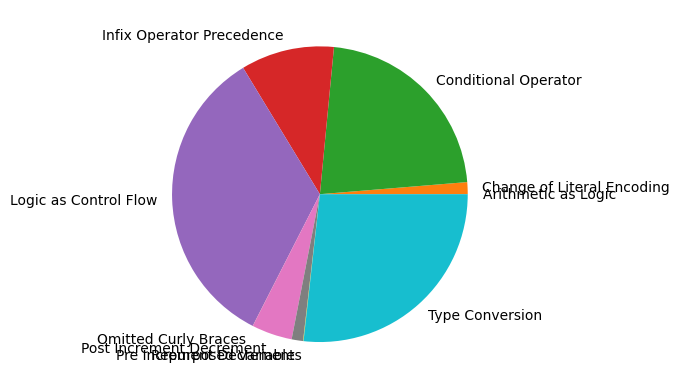

In [ ]:
plt.pie(tst.iloc[0].values, labels=tst.columns)

In [ ]:
tst.apply(lambda x: x * 100/ tst.sum(axis=1))

,Arithmetic as Logic,Change of Literal Encoding,Conditional Operator,Infix Operator Precedence,Logic as Control Flow,Omitted Curly Braces,Post Increment Decrement,Pre Increment Decrement,Repurposed Variables,Type Conversion
0,0.021086,1.287184,22.171832,10.210986,33.797131,0.013752,4.434855,1.24715,0.051646,26.764377


RQ2- Em que medida a “distribuição” destes ACs através dos módulos?


RQ3- Qual a correlação entre as métricas de qualidade de software e os átomos de confusão no ecosistema? (no geral)


RQ4 - Qual a correlação entre frameworks/base/core e packages/apps

## Heatmap


In [69]:
def acronym_ac(ac_name: str) -> str:
    ac_map = {
        "Change of Literal Encoding":"CoLE",
        "Conditional Operator":"CO",
        "Infix Operator Precedence":"IOP",
        "Logic as Control Flow":"LaCF",
        "Post Increment Decrement":"Post-Inc/Dec",
        "Pre Increment Decrement":"Pre-Inc/Dec",
        "Type Conversion":"TC",
        "Omitted Curly Braces":"OCB",
        "Repurposed Variables": "RV",
        "Arithmetic as Logic" : "AaL"
    }
    return f"{ac_map.get(ac_name, ac_name)}"

def pivot_results(df: pd.DataFrame) ->pd.Series:
    df_pivoted = pd.pivot_table(df, columns="ac", values="qty")
    # df_pivoted["counts"] = df_pivoted.infer_objects(copy=False).fillna(0).to_numpy().sum()
    filter_list = ["ac", "project_name"]
    # df_pivoted = df_pivoted.apply(lambda x: x / df_pivoted["counts"] if df_pivoted["counts"] != 0 else 0)
    df_pivoted.columns = [acronym_ac(x) for x in df_pivoted.columns if x not in filter_list]
    # df_pivoted["project_name"] = project_name
    return df_pivoted.loc["qty"]


In [70]:
heatmap = pd.DataFrame()
for project_name in ALL_PROJECTS:
    asd = pivot_results(report_types_of_acs(project_name))
    asd = pd.DataFrame(asd.to_dict(), index=[project_name])
    heatmap = pd.concat([heatmap, asd])
heatmap = heatmap.fillna(0)
heatmap_normalized = heatmap.div(heatmap.sum(axis=1), axis=0)
heatmap_normalized = heatmap_normalized.fillna(0)
heatmap


,CO,IOP,LaCF,TC,CoLE,Post-Inc/Dec,Pre-Inc/Dec,RV,AaL,OCB
external/crcalc,12.0,14.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
external/ow2-asm,348.0,29.0,195.0,92.0,47.0,167.0,13.0,0.0,0.0,0.0
packages/modules/AdServices,319.0,22.0,890.0,163.0,24.0,18.0,0.0,0.0,0.0,0.0
external/google-java-format,92.0,4.0,149.0,3.0,0.0,7.0,1.0,0.0,0.0,0.0
external/ims,28.0,4.0,83.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
packages/modules/Uwb,109.0,203.0,234.0,345.0,0.0,17.0,0.0,0.0,0.0,0.0
external/skia,9.0,25.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
external/nanohttpd,27.0,2.0,33.0,13.0,4.0,9.0,3.0,0.0,0.0,0.0
external/apache-commons-bcel,136.0,10.0,162.0,28.0,1.0,42.0,18.0,2.0,0.0,0.0


<Axes: >

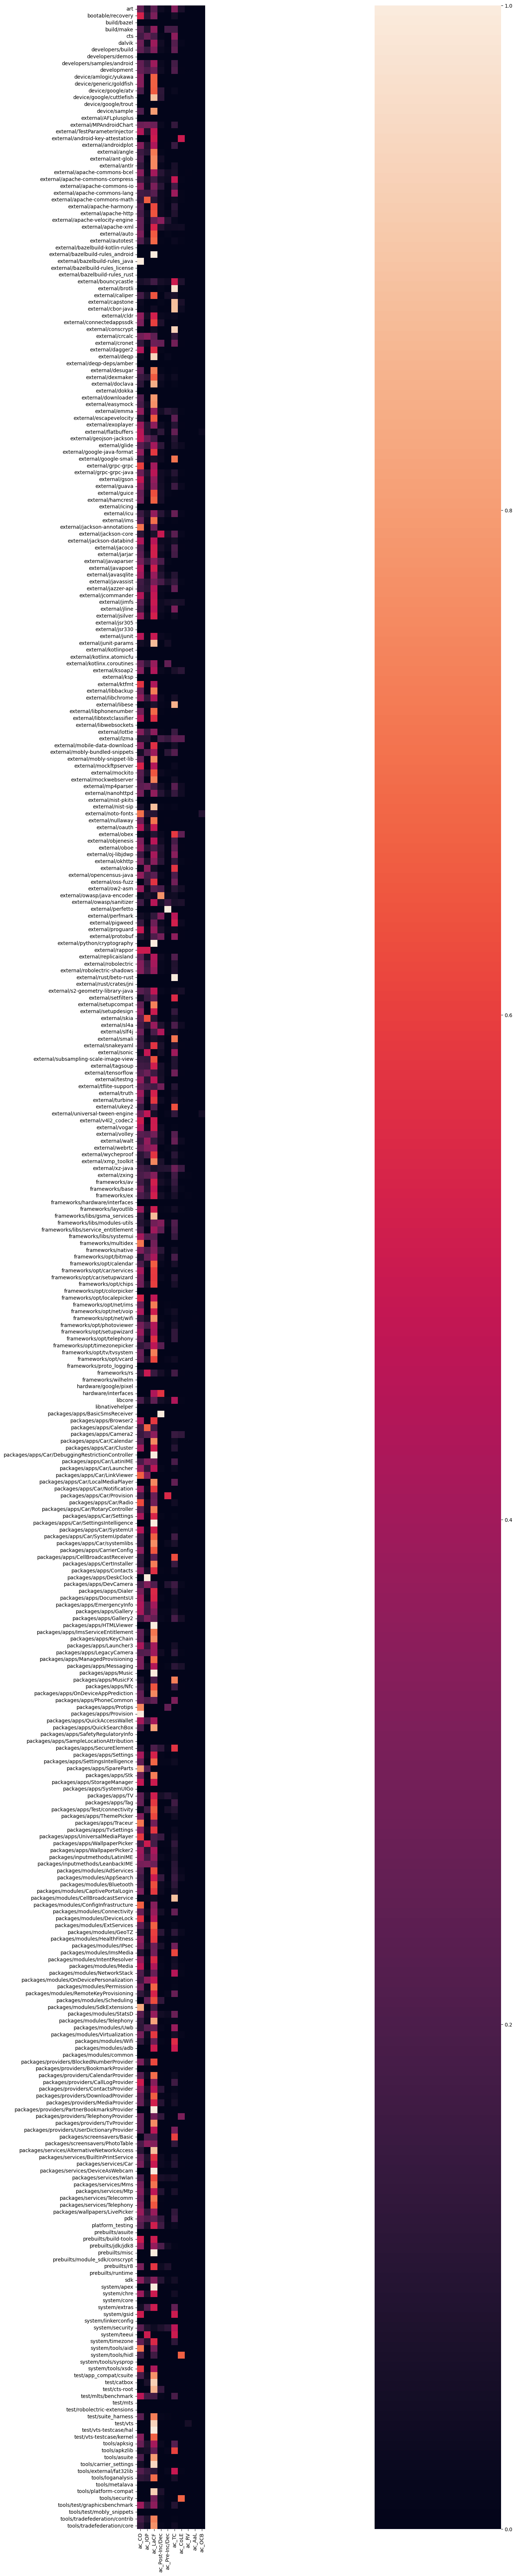

In [14]:
plt.figure(figsize=(120, 90))
sns.heatmap(heatmap_normalized.sort_index(), square=True,)

In [80]:
from matplotlib.colors import LogNorm, Normalize
"""Aggregates a heatmap plot by domain, e.g. packages, frameworks, external...
"""
def aggregate_heatmap_by_domain(df: pd.DataFrame, normalize=False, attenuate: int=0) -> pd.DataFrame:
    domains = set([i.split("/")[0] for i in df.index])
    df_heatmap_aggregated = pd.DataFrame()
    for domain in domains:
        temp = df.loc[df.index.str.startswith(domain)]
        temp = temp.agg("sum")
        if normalize:
            temp /= temp.sum()
        if attenuate:
            temp /= attenuate
        temp = pd.DataFrame(temp.to_dict(), index=[domain])
        df_heatmap_aggregated = pd.concat([df_heatmap_aggregated, temp])
    return df_heatmap_aggregated

def filter_heatmap_by_query(df: pd.DataFrame, query: str) -> pd.DataFrame:
    if not query and not isinstance(query, str):
        raise ValueError("Please add a valid query.")
    return df.loc[df.index.str.startswith(query)]

def print_heatmap(df: pd.DataFrame, title="Heatmap", annot=False):
    plt.figure(figsize=(30, 9))
    cmap = [i for i in zip(np.linspace(255, 127, 50), np.linspace(255, 0, 50), np.linspace(255, 255, 50))]
    ax = sns.heatmap(df.sort_index().T, cmap="Purples",linewidths=.5, annot=annot, square=True, fmt=".0%", annot_kws={"fontsize": "small"}, norm=LogNorm())
    ax.set_title(title, fontdict={"fontsize": "x-large", "fontweight": "bold"})
    return ax

In [29]:
filter_heatmap_by_query(heatmap_normalized, "packages")

,ac_CO,ac_IOP,ac_LaCF,ac_TC,ac_CoLE,ac_Post-Inc/Dec,ac_Pre-Inc/Dec,ac_RV,ac_AaL,ac_OCB
packages/modules/AdServices,0.222145,0.015320,0.619777,0.113510,0.016713,0.012535,0.000000,0.0,0.0,0.0
packages/modules/ConfigInfrastructure,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/modules/CaptivePortalLogin,0.310345,0.000000,0.586207,0.068966,0.000000,0.034483,0.000000,0.0,0.0,0.0
packages/apps/Car/Notification,0.386667,0.026667,0.586667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/apps/Calendar,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
packages/apps/LegacyCamera,0.212500,0.225000,0.395833,0.116667,0.008333,0.041667,0.000000,0.0,0.0,0.0
packages/apps/Car/Calendar,0.208333,0.000000,0.750000,0.041667,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/apps/SafetyRegulatoryInfo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
packages/modules/Uwb,0.120044,0.223568,0.257709,0.379956,0.000000,0.018722,0.000000,0.0,0.0,0.0


<Axes: title={'center': 'Heatmap'}>

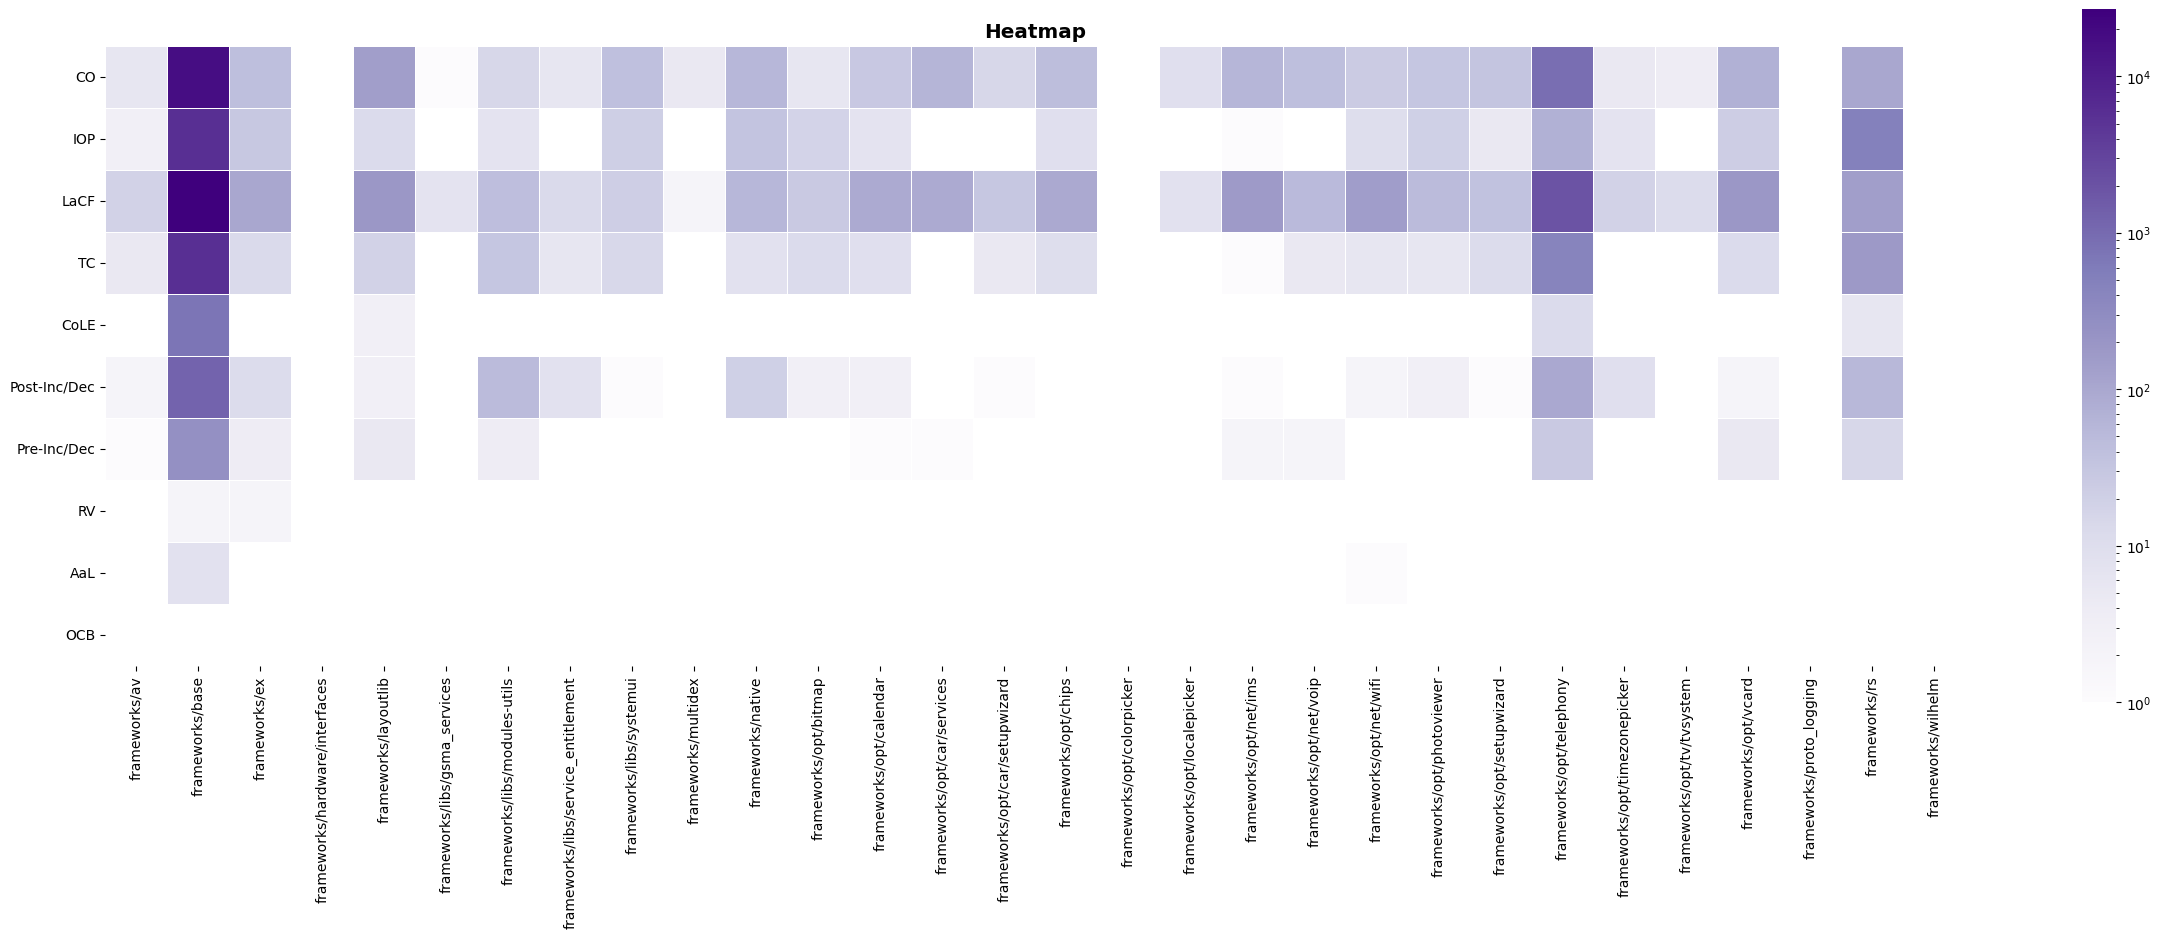

In [81]:
print_heatmap(filter_heatmap_by_query(heatmap, "frameworks"), annot=False)

<Axes: title={'center': 'Heatmap for "packages"'}>

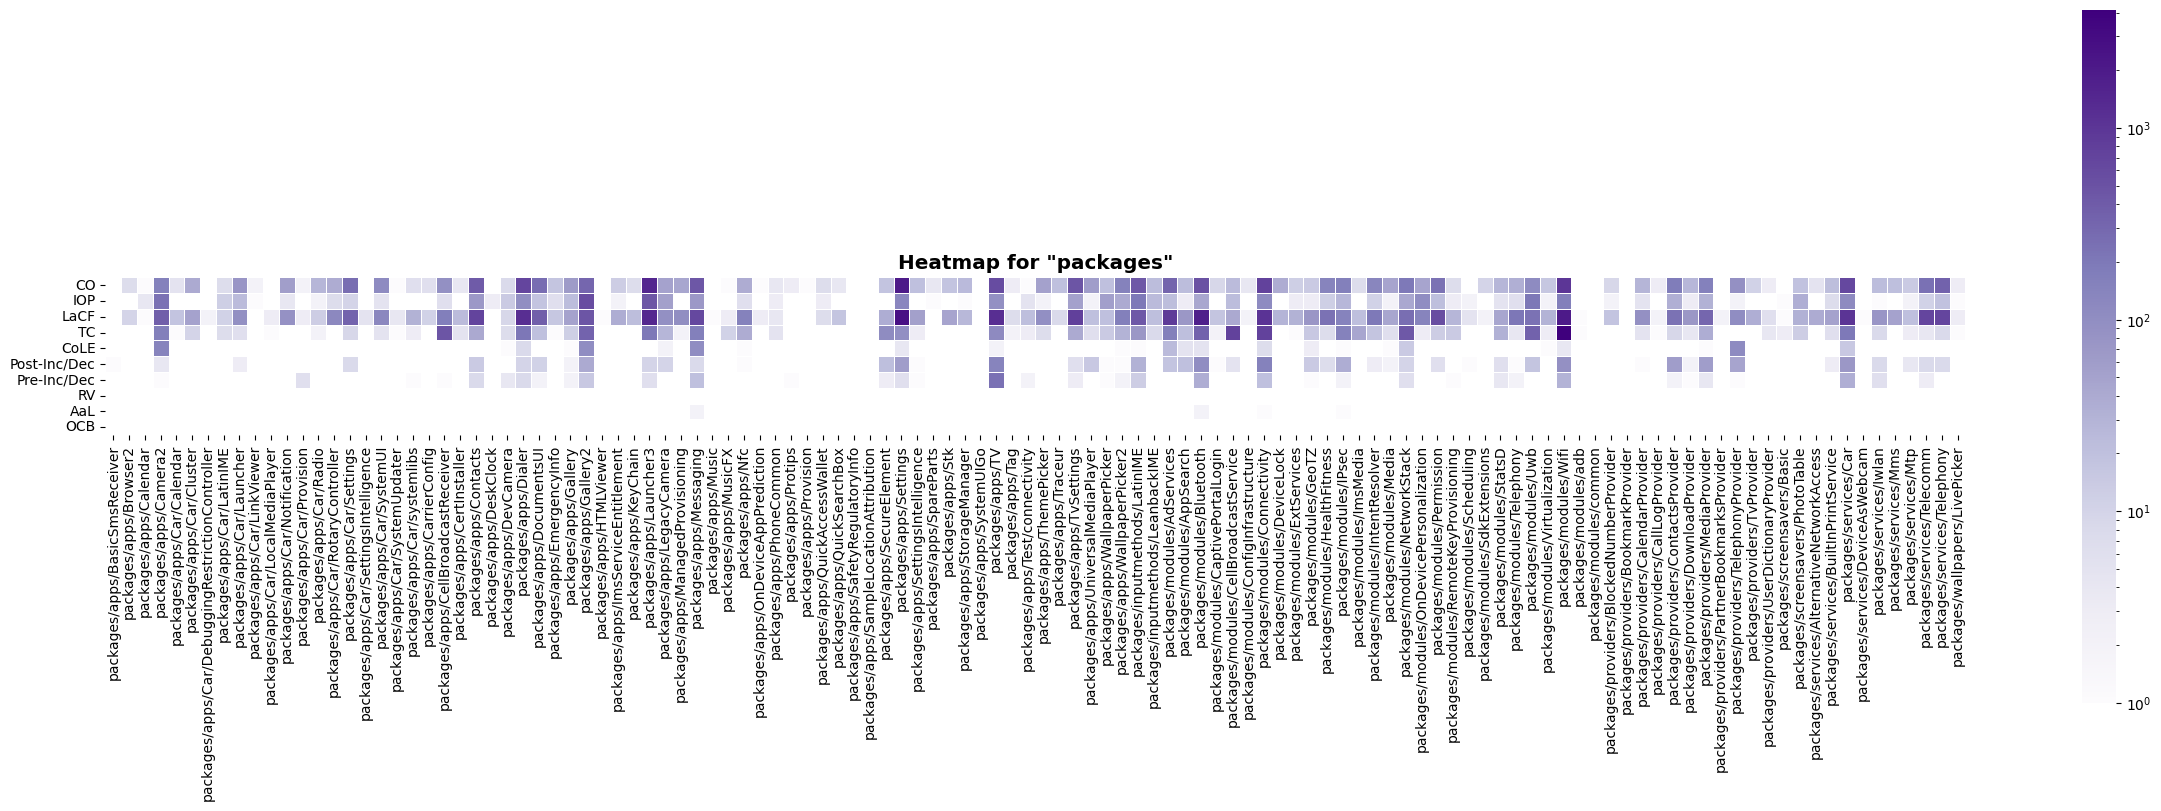

In [84]:
print_heatmap(filter_heatmap_by_query(heatmap, "packages"), title="Heatmap for \"packages\"", annot=False)

<Axes: title={'center': 'AC count for every root repository'}>

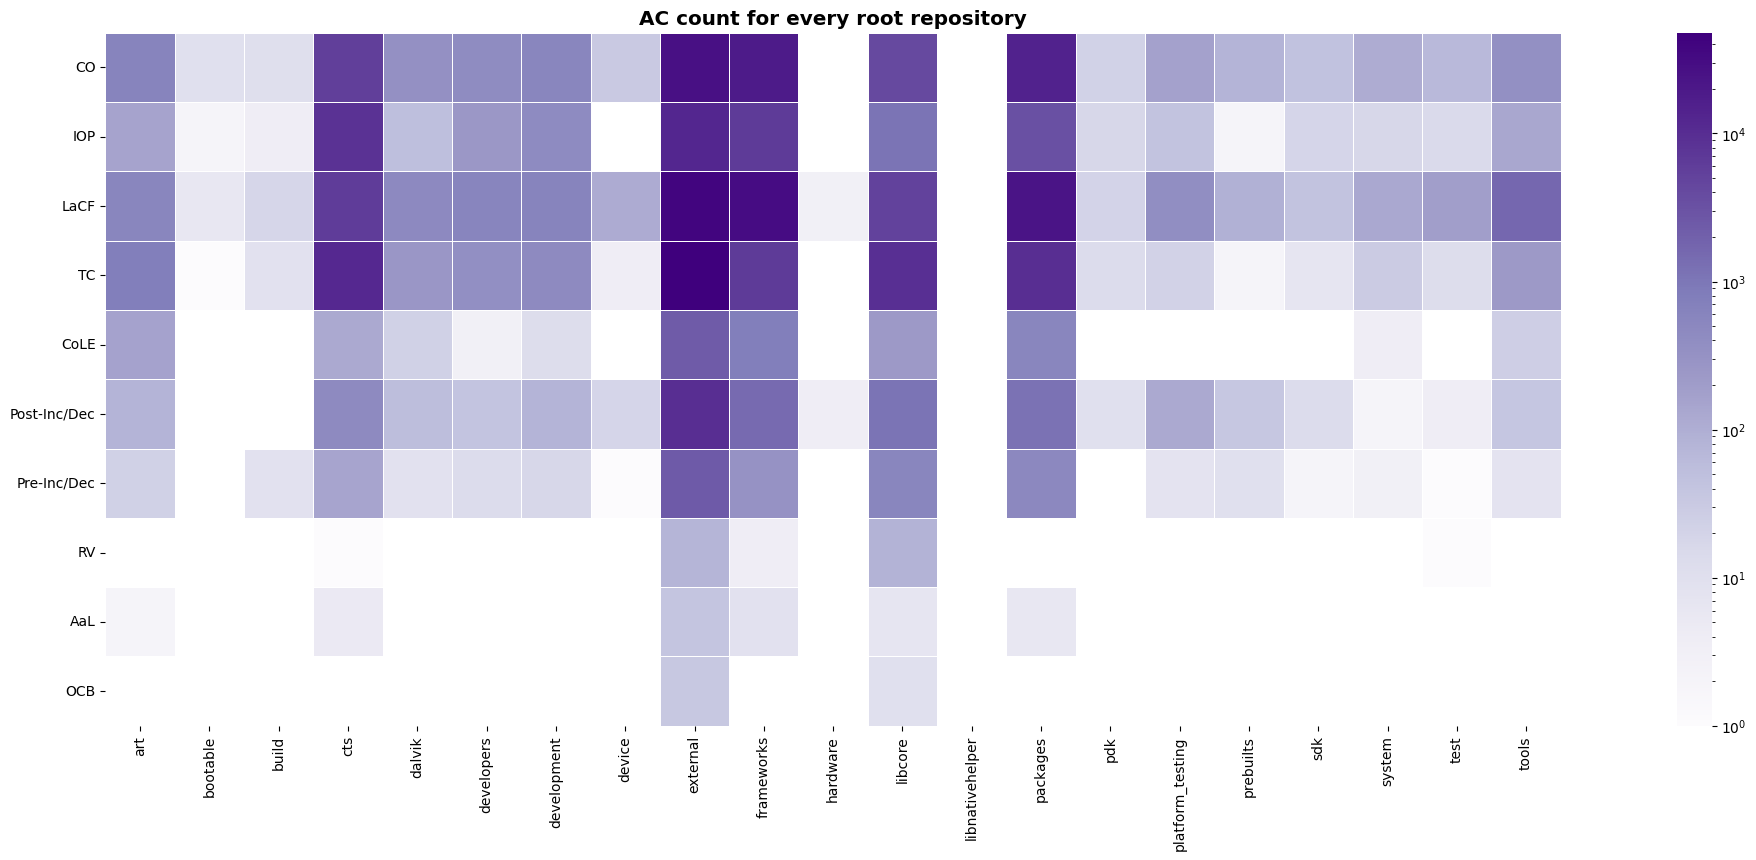

In [85]:
print_heatmap(aggregate_heatmap_by_domain(heatmap), title="AC count for every root repository", annot=False)

## Scatterplot AC x LoC

In [113]:
def get_ac_count_and_loc(project_name: str) -> dict:
    a = acs_in_a_project(project_name)
    a["loc"] = a["loc"].astype(int)
    group = a.groupby("path").aggregate({"ac_count": "sum", "loc": "max"})
    group = group.sum()
    return {
        "project_name": project_name,
        "ac_count": group["ac_count"],
        "loc": group["loc"]
    }

records = []
with ThreadPoolExecutor(max_workers=5) as executor:
    jobs = [executor.submit(get_ac_count_and_loc, project) for project in ALL_PROJECTS]
    for job in as_completed(jobs):
        records.append(job.result())
df_ac_x_loc = pd.DataFrame.from_records(records)


,project_name,ac_count,loc
0,external/crcalc,41,2730
1,external/ims,119,11582
2,external/google-java-format,256,14269
3,packages/modules/ConfigInfrastructure,6,1795
4,device/google/cuttlefish,9,1661
...,...,...,...
365,external/apache-commons-bcel,399,38697
366,packages/modules/NetworkStack,954,50400
367,packages/apps/Settings,5024,318768
368,external/jackson-databind,1248,102358


In [150]:
domains = set([i.split("/")[0] for i in df_ac_x_loc["project_name"]])
df_ac_x_loc_aggregated = pd.DataFrame()
for domain in domains:
    temp = df_ac_x_loc.loc[df_ac_x_loc["project_name"].str.startswith(domain)]
    temp = temp.agg("sum")
    temp["project_name"] = domain
    temp = pd.DataFrame(temp.to_dict(), index=[0])
    df_ac_x_loc_aggregated = pd.concat([df_ac_x_loc_aggregated, temp], ignore_index=True)

In [151]:
df_ac_x_loc_aggregated

,project_name,ac_count,loc
0,platform_testing,741,64401
1,tools,2400,243093
2,build,51,4155
3,pdk,82,7140
4,cts,32902,1551282
5,development,2192,159546
6,frameworks,64634,4405789
7,device,172,12998
8,test,284,24156
9,external,141704,6113218


Text(0.5, 1.0, 'Size of projects vs number of ACs')

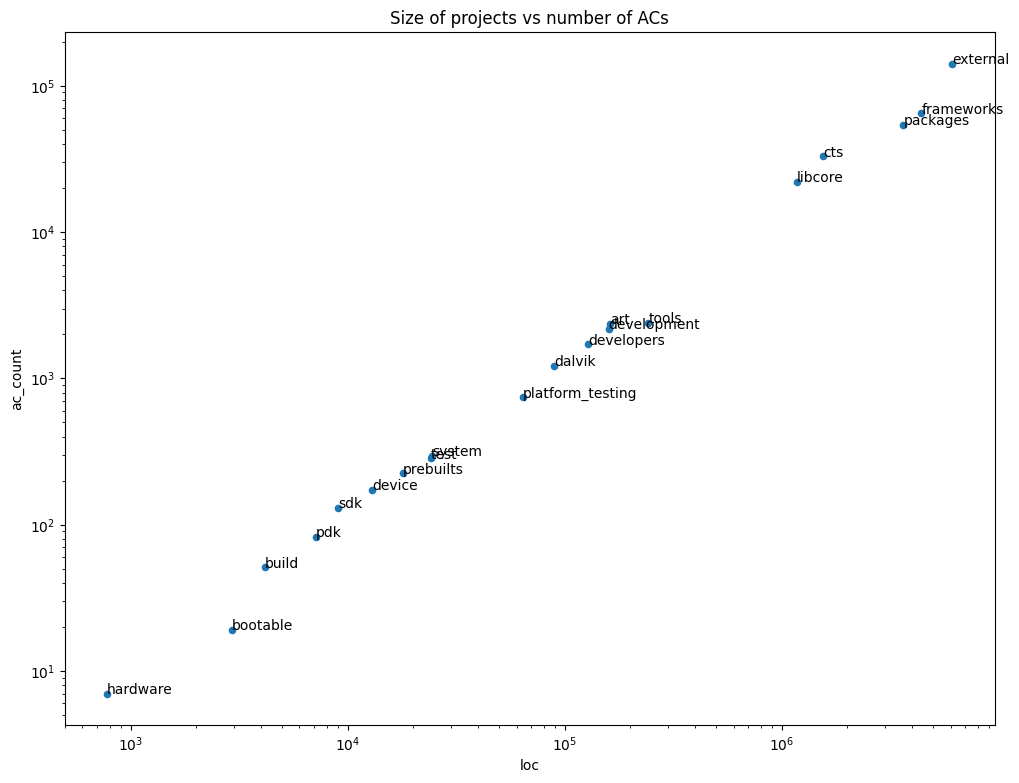

In [160]:
ax = df_ac_x_loc_aggregated.plot(kind="scatter", x="loc", y="ac_count")
ax.set_yscale("log")
ax.set_xscale("log")

top_projects = df_ac_x_loc_aggregated.sort_values("ac_count", ascending=False).head(20)["project_name"].to_list()
for idx, row in df_ac_x_loc_aggregated.iterrows():
    if row["project_name"] in top_projects:
        ax.annotate(row['project_name'], (row['loc'], row['ac_count']))
ax.figure.set_size_inches((12,9))
plt.title("Size of projects vs number of ACs")

# Violin plot

In [ ]:
files_with_acs = []
files_without_acs = []
for project_name in ALL_PROJECTS:
    files_with_acs.extend(report_files_with_acs(project_name).to_list())
    files_without_acs.extend(report_files_without_acs(project_name).to_list())
files_with_acs = pd.Series(files_with_acs)
files_without_acs = pd.Series(files_without_acs)

In [ ]:
files_with_acs[0]

'/AOSP/external/flatbuffers/grpc/flatbuffers-java-grpc/src/main/java/com/google/flatbuffers/grpc/FlatbuffersUtils.java'

In [ ]:
try:
    df_ck_in_file = pd.read_csv("ck_files_with_acs.csv")
except:
    df_ck_in_file = pd.DataFrame()
if df_ck_in_file.empty:
    df_ck_in_file = []
    cols = []
    for file in files_with_acs:
        result = ck_in_file(file)
        df_ck_in_file.extend(result.to_records(index=False))
        if not cols:
            cols = result.columns.to_list()
    df_ck_in_file = pd.DataFrame.from_records(df_ck_in_file, columns=cols)
    df_ck_in_file = df_ck_in_file.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck_in_file.to_csv("ck_files_with_acs.csv", index=False)


In [ ]:
try:
    df_ck_ac_not_in_file = pd.read_csv("ck_files_without_acs.csv")
except:
    df_ck_ac_not_in_file = pd.DataFrame()
if df_ck_ac_not_in_file.empty:
    df_ck_ac_not_in_file = []
    cols = []
    for file in files_without_acs:
        result = ck_in_file(file)
        df_ck_ac_not_in_file.extend(result.to_records(index=False))
        if not cols:
            cols = result.columns.to_list()
    df_ck_ac_not_in_file = pd.DataFrame.from_records(df_ck_ac_not_in_file, columns=cols)
    df_ck_ac_not_in_file = df_ck_ac_not_in_file.groupby("file_path").agg(agg_methods, numeric_only=True).reset_index()
    df_ck_ac_not_in_file.to_csv("ck_files_without_acs.csv", index=False)

Text(0.5, 0.98, 'AOSP metrics comparison')

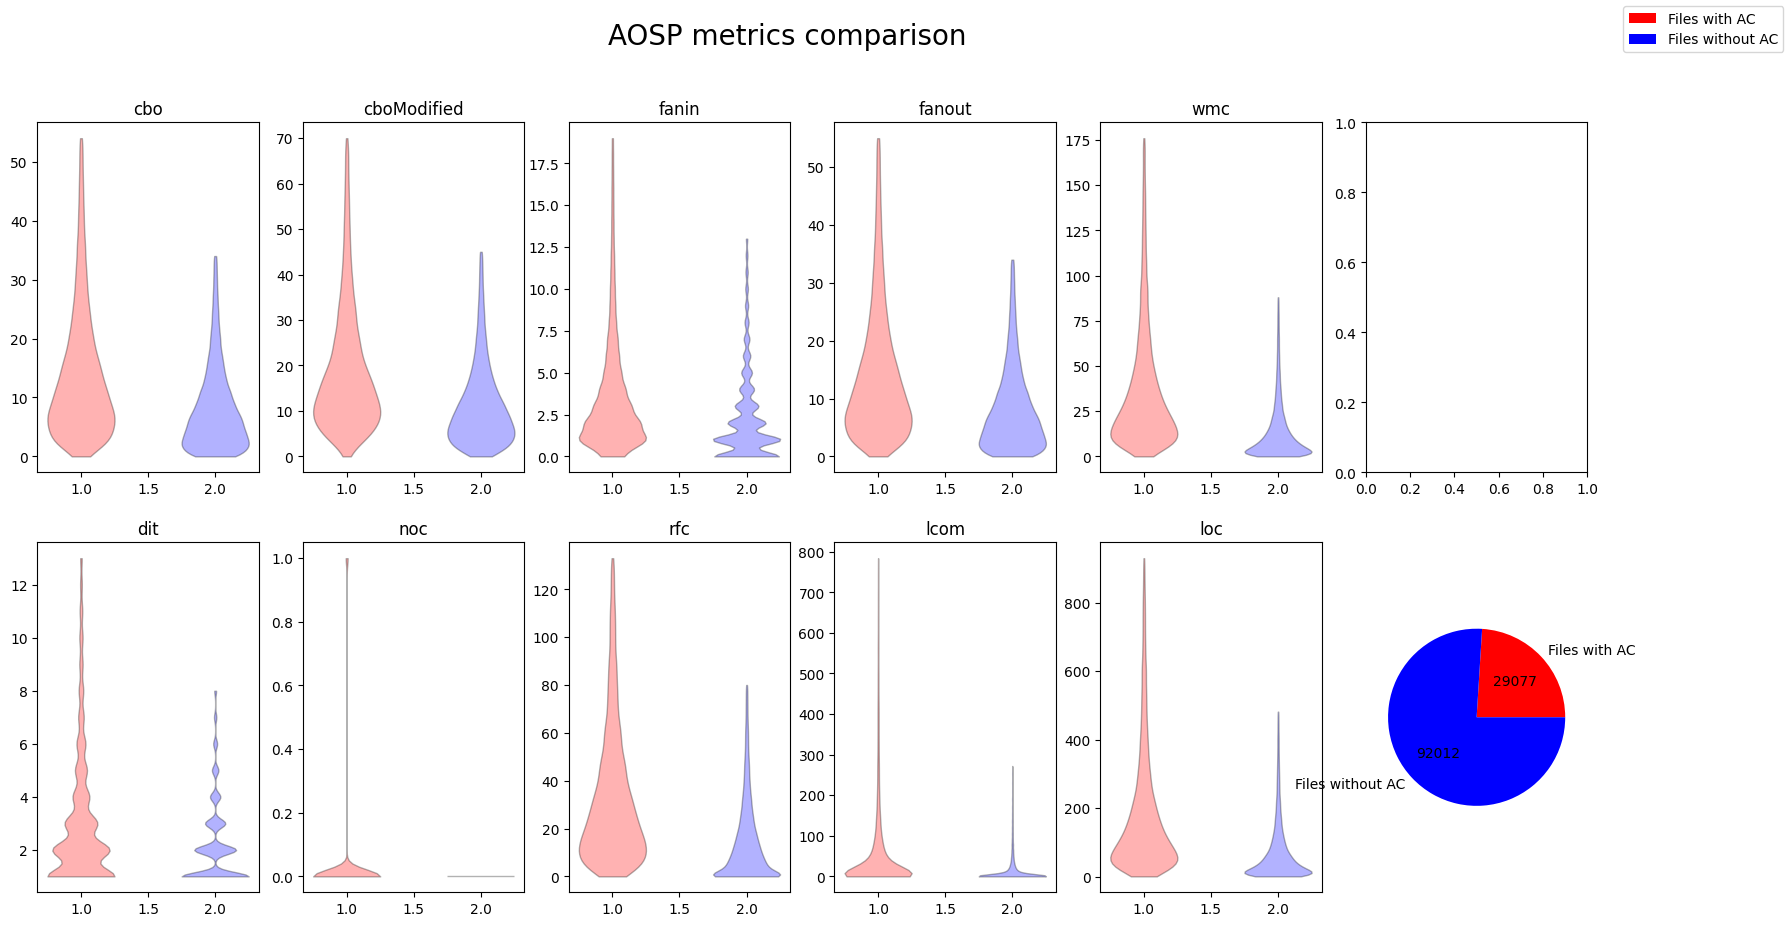

In [ ]:
# plot violins
VIOLIN_COLORS = ["red", "blue"]
columns_to_check = ["cbo", "cboModified", "fanin", "fanout", "wmc","dit", "noc", "rfc", "lcom", "loc"]
fig, axs = plt.subplots(nrows=len(columns_to_check)//5, ncols=5+1, figsize=(20,10))

n_files_with_ac = df_ck_in_file["file_path"].size
n_files_without_ac = df_ck_ac_not_in_file["file_path"].size
set_sizes = [n_files_with_ac, n_files_without_ac]
_,_, autotexts = axs[-1, -1].pie(set_sizes, labels=["Files with AC", "Files without AC"], autopct='', colors=VIOLIN_COLORS)
for i, txt in enumerate(autotexts):
    txt.set_text(f"{set_sizes[i]}")

for i, column in enumerate(columns_to_check):
    if column == "file_path":
        continue
    eye = i // 5
    j = i % 5
    quantile_with_ac = df_ck_in_file[column].quantile(.95)
    quantile_without_ac = df_ck_ac_not_in_file[column].quantile(.95)
    filtered_with_ac = df_ck_in_file[df_ck_in_file[column] < quantile_with_ac][column]
    filtered_without_ac = df_ck_ac_not_in_file[df_ck_ac_not_in_file[column] < quantile_without_ac][column]
    try:
        violins = axs[eye,j].violinplot([filtered_with_ac, filtered_without_ac], showextrema=False)
    except:
        continue
    axs[eye,j].set_title(column)
    for c, body in enumerate(violins["bodies"]):
        body.set_facecolor(VIOLIN_COLORS[c])
        body.set_edgecolor("black")
fig.legend()
plt.suptitle("AOSP metrics comparison", fontsize=20)


In [ ]:
df_ck_in_file

,file_path,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,/AOSP/art/benchmark/type-check/src/TypeCheckBe...,17,31,14,17,33,43,6,2,55,...,44,0,39,2,0,0,0,47,1,0
1,/AOSP/art/libartservice/service/java/com/andro...,96,107,11,96,128,10,0,172,44,...,84,3,80,6,0,5,14,798,38,0
2,/AOSP/art/libartservice/service/java/com/andro...,34,36,2,34,136,3,0,110,140,...,94,25,75,4,0,1,2,471,27,0
3,/AOSP/art/libartservice/service/java/com/andro...,41,46,5,41,36,9,0,59,41,...,29,1,26,3,0,4,5,152,2082,0
4,/AOSP/art/libartservice/service/java/com/andro...,2,10,8,2,8,1,0,3,15,...,1,0,1,0,0,0,0,30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29072,/AOSP/tools/tradefederation/core/test_result_i...,5,46,41,5,46,1,1,16,208,...,29,8,14,2,0,0,0,105,1,0
29073,/AOSP/tools/tradefederation/core/test_result_i...,3,78,75,3,28,1,0,21,73,...,14,4,10,2,0,0,0,115,17,0
29074,/AOSP/tools/tradefederation/core/util_apps/Con...,9,10,1,9,48,3,0,43,59,...,46,3,32,4,1,0,0,165,0,0
29075,/AOSP/tools/tradefederation/core/util_apps/Tel...,16,17,1,16,16,6,0,22,0,...,20,0,18,5,1,2,0,100,4,0
